<img style='float:right;border-radius:5%;width:20%;height:20%;background-blend-mode:screen;margin-right:25px;margin-top:25px;' src='mirum_purple.png'>
<br>
<br>
<br>
<br>

<h1 style='text-align:center;'> Market Basket Analysis </h1>
<br>

**Instructor**: Elie Kawerk, Ph.D. 
<p style="padding-left:74px"> Data Scientist at Mirum Agency MEA </p>

<img style='float:right;width:250px;height:210px;margin-right:30px;padding-left:15px;' src='http://1.bp.blogspot.com/-sYQ4ex-tM0E/UnKYjSpV5cI/AAAAAAAABLY/ZXWnHiADtyw/s1600/social-media-humor-21.png'>

# Introduction

The goal of market basket analysis is to discover items that are most likely to be purchased together. Such discoveries are usually done by mining historical data of transactions. This discipline is very important for e-commerce websites and retail magazines as it allows them to better organize their layouts. 

In this workshop, you will use the customers' purchase history of a grocery store to cluster items that should be placed or bundled together.

The datasets are available in this repo as `csv` files:

- `purchase_history.csv`: contains the data of individual baskets or carts. It consists of 2 columns, the first column `customer_id` refers to the id of a customer, while the 2nd column `basket` refers to the item ids purchased by the customer. Note that the item ids are separated by commas.
<br>
<br>
- `item_to_id.csv`: contains the mapping between the names of the grocery items (`Item_name`) and their corresponding ids (`Item_id`).


### API Versions

You can first start by checking the versions of the libraries that you'll be using throughout the workshop.

In [2]:
# Load the watermark extension
# If watermark is not available, go to your terminal and type: pip install watermark
%load_ext watermark

In [3]:
# Enter your name here
%watermark  -a "Author: Elie Kawerk; Date: " -dt -v -p sklearn,pandas,matplotlib,seaborn

Author: Elie Kawerk; Date:  2018-08-07 12:35:37 

CPython 3.6.4
IPython 6.2.1

sklearn 0.19.2
pandas 0.23.3
matplotlib 2.2.2
seaborn 0.9.0


# 1. Import Libraries

In [4]:
# Data Analysis and Plotting
import pandas as pd  # pandas 
import matplotlib.pyplot as plt # pyplot
import numpy as np # numpy
import seaborn as sns # seaborn
from mpl_toolkits.mplot3d import Axes3D # 3D plotting
from matplotlib import cm
%matplotlib inline

# Other utilities
import itertools as it
from collections import Counter

# display
from IPython.display import display

# Set custom preferences for displaying and visualizing data
sns.set_style('white')
pd.set_option('max_colwidth', 120)
pd.set_option('max_columns', 200)
pd.set_option('precision', 2)

# 2. Import and Inspect the Datasets

You can start by reading the two `csv` files containing the datasets.

**Task**: Use `pd.read_csv` to read the two available datasets as `pandas.DataFrame`s. 

- Assign the dataframe corresponding to `purchase_history.csv` to `df_baskets`.
- Assign the dataframe corresponding to `item_to_id.csv` to `df_categories`.

In [5]:
# Read purchase_history.csv; assign the dataframe to `df_baskets`
df_baskets = pd.read_csv('purchase_history.csv')

# Read item_to_id.csv; assign the dataframe to `df_categories`
df_categories = pd.read_csv('item_to_id.csv')

**Task**: Inspect the head of df_baskets.

In [6]:
# Inspect the head of df_baskets
df_baskets.head()

customer_id                                                   basket
0       222087                                                    27,26
1      1343649                                                  6,47,17
2       404134                             18,12,23,22,27,43,38,20,35,1
3      1110200                                       9,23,2,20,26,47,37
4       224107  31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,40,47,12,7

**Task**: Set `customer_id` as the index of `df_baskets`. Inspect `df_basket` again to make sure that everything went OK.

In [7]:
# Set `customer_id` as the index of `df_baskets`
df_baskets.set_index('customer_id', inplace=True, drop=True)

# Inspect the head of `df_baskets` again ...
df_baskets.head()

basket
customer_id                                                         
222087                                                         27,26
1343649                                                      6,47,17
404134                                  18,12,23,22,27,43,38,20,35,1
1110200                                           9,23,2,20,26,47,37
224107       31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,40,47,12,7

**Task**: Inspect the head of `df_categories`. Inspect the names of `df_categories` columns; did you notice anything about these names?

In [8]:
# Inspect the head of `df_categories`
df_categories.head()

Item_name  Item_id
0           coffee       43
1              tea       23
2            juice       38
3             soda        9
4  sandwich loaves       39

In [9]:
# make column names lowercase
df_categories.columns = df_categories.columns.str.lower()

In [10]:
# set 'item_id' as index
df_categories.set_index('item_id', inplace=True)

# 3. Missing Values

**Task**: Check the number of missing values per column for each of the two dataframes. Devise a method to treat these missing values in case they are present.

In [11]:
# Inspect the number of missing values per column for `df_baskets` 
df_baskets.isnull().sum()

basket    0
dtype: int64

In [12]:
# Inspect the number of missing values per column for `df_categories` 
df_categories.isnull().sum()

item_name    0
dtype: int64

# 4. Construct a Customer-Item Dataframe 

You will now construct a customer-item dataframe where each row has the the customer ids as an index and the item ids as columns. Each cell in this table should contain the number of purchases made by a certain customer for a certain item.

You will first start by building a transaction-items dataframe where each column corresponds to an item id.

**Tasks**:

- Write a function called `customer_item_count` that takes a `pandas.Series` `s` as an argument:
    - Raise a `ValueError` if the `basket` column is not contained in `s`.
    - Manipulate the `basket` column in `s` to determine the list of items bought by a customer. Assign the result to `items`.
    - Return a `pandas.Series` object whose index corresponds to the id of an item and whose values corresponds to the number of purchases of that item.  You can use the `Counter` function from the `collections` module to facilitate your task.
    
    
- Apply the function `customer_item_counts` to the `df_baskets` dataframe using the `.apply()` method:
    - Make sure to apply this function along the rows of `df_basket` by setting the `axis` argument correctly. 
    - Finally chain the result with the method `.fillna()` to fill missing values with zeros. Assign the final dataframe to `df_customer_transaction`.

In [13]:
def customer_item_count(s):
    '''
    This function takes a pandas.Series s corresponding to a row in df_baskets
    and returns a pandas.Series whose index corresponds to the id of an item
    and whose values corresponds to the number of purchases of a particular
    item.
    
    Parameters
    ---------
    s: pandas Series
    
    Returns
    --------
    pandas Series    
    
    Raises
    ------
    ValueError if the 'basket' column is not contained in s
    
    '''
    
    # Make sure that 'basket` is contained in s
    if 'basket' not in s.index:
        raise ValueError("basket is not a column in the passed dataframe")
    
    # Compute the list of items in s['basket']
    items = [int(item) for item in s['basket'].split(',')]
    
    # Return a pd.Series of whose index corresponds to item ids and
    # whose values corresponds to counts of items
    return pd.Series(Counter(items), dtype=np.int16)

#Transform df_baskets into a tidy form
df_customer_transaction = df_baskets.apply(customer_item_count,axis='columns').fillna(0, downcast='int')

Now that you are done from constructing a transaction-item dataframe, it's time to construct a customer-item dataframe that takes into account all historical purchases made by a customer.

**Task**: 

Manipulate `df_customer_transaction` to obtain a customer-item dataframe in which the index corresponds to the id of a customer and where the cells contain the total number of purchases of an item. Assign the result to `df_customer_items`.

*Hint*: You can use the `groupby()` method to achieve this task.

In [14]:
# Group by customer_id
df_customer_items = df_customer_transaction.groupby(df_customer_transaction.index).sum()

**Task**

Print out a random sample of `df_customer_items` consisting of 10 rows.

In [15]:
# print out a random sample consisting of 10 records
df_customer_items.sample(10)

1    2    3    4    5    6    7    8    9    10   11   12   13  \
customer_id                                                                    
632533       0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   
1174954      0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0   
761044       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
134092       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1355819      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
783454       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
502143       1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
1130072      0.0  1.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0   
1274679      0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0   
1390225      2.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0   

              14   15   16   17   18   19   20   21   22   23   24   25   26  \
customer_id                                                                    
632533       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1174954      0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0   
761044       0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   
134092       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1355819      0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0   
783454       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
502143       0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   
1130072      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1274679      0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1390225      2.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   

              27   28   29   30   31   32   33   34   35   36   37   38   39  \
customer_id                                                                    
632533       1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0   
1174954      0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  1.0  1.0   
761044       0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0   
134092       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1355819      0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
783454       0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
502143       1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0   
1130072      1.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
1274679      0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0   
1390225      1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0   

              40   41   42   43   44   45   46   47   48  
customer_id                                               
632533       1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  
1174954      1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  
761044       0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  
134092       0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1355819      0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
783454       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
502143       0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  
1130072      1.0  0.0  1.0  1.0  0.0  0.0  2.0  0.0  0.0  
1274679      0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  
1390225      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [16]:
# Downcast the columns to integer
for col in df_customer_items.columns:
    df_customer_items[col] = pd.to_numeric(df_customer_items[col], downcast='integer')

# 5. Most purchased item

The owner of the store wants to know which items in the transcations database was purchased the most. For this purpose, you will analyze the data to find the most purchased item.

**Tasks**:

- Manipulate `df_customer_items` to find the total count of purchases of the different items. Assign the result to `item_purchases`.
- Use `item_purchases` to find the name and the id of the most purchased item. Also find the total number of times this item was purchased.

In [17]:
# Construct 'item_purchases'
item_purchases = df_customer_items.sum(axis=0)

# Find the id of the most purchased item
max_purchased_item_id = int(item_purchases.idxmax())

# Find the name of the most purchased item
max_purchased_item_name = df_categories.loc[max_purchased_item_id, 'item_name']

# Find the number of times the most purchased item appeared
max_purchased_item_count = int(item_purchases.max())

# print the result
print("The most purchased item was {0}, it has the item id {1} and was purchased {2} times.".format(
                  max_purchased_item_name, max_purchased_item_id, max_purchased_item_count))

The most purchased item was lettuce, it has the item id 2 and was purchased 14473 times.


# 6. Customer who Purchased the Greatest Number of Items

The store's owner wants to reward the customer who purchased the greatest number of items. Your task here is to identify this customer's id and determine the total number of items she/he purchased throughout the studied period.

**Tasks**:

- Manipulate `df_customer_items` to find the total count of purchases for all customers. Assign the result to `customer_purchases`.
- Use `item_purchases` to find the id of the customer who purchased the greatest number of items. Also find the total number of items bought by this customer.

In [18]:
# Sum over columns to find the # of purchases of each customer
customer_purchases = df_customer_items.sum(axis=1)

# Find the id of the customer who purchased the maximum number of items
most_purchasing_customer_id = customer_purchases.idxmax()

# Find the total number of items purchased by the most purchasing customer
tot_items_purchased = int(customer_purchases.max())

print("The customer who purchased the greatest number of items has the id {0},"
      " and has purchased {1} items.".format(most_purchasing_customer_id, tot_items_purchased))

The customer who purchased the greatest number of items has the id 269335, and has purchased 72 items.


# 7 Distribution of basket size

The store's owner wants to get an idea of the distribution of the customers' basket size and to visualize how it looks like. 

You will help the owner in this task by using the awesome `seaborn` library.

**Task**:

- Use `sns.distplot()` to plot the distribution of basket size.
- Also plot vertical lines indicating the median and the average basket size.

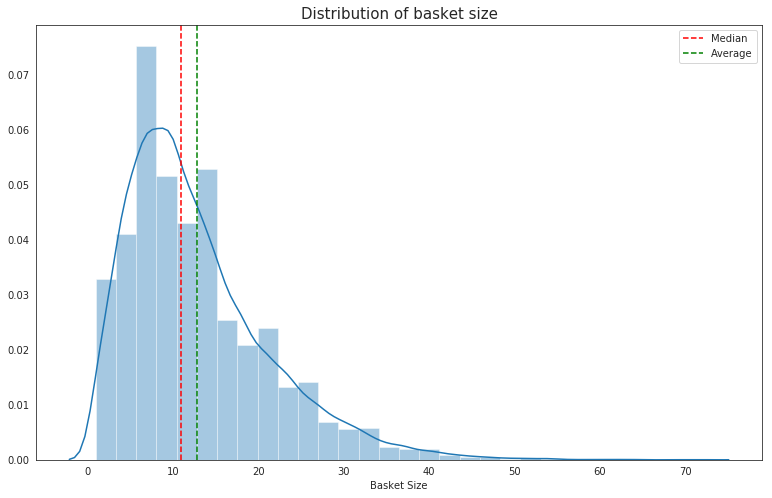

In [19]:
fig, ax = plt.subplots(figsize=(13,8))

# Plot the distribution of basket size
sns.distplot(customer_purchases, hist_kws={'edgecolor':'white',}, bins=30, ax=ax)
ax.axvline(x=customer_purchases.median(), color='red', ls='--', label='Median')
ax.axvline(x=customer_purchases.mean(), color='green', ls='--', label='Average')
ax.set_title("Distribution of basket size", fontsize=15)
ax.set(xlabel='Basket Size')
ax.legend(loc='best')
plt.show()

# 8. Most purchasing customer by item

For each item, find the id of the customer who baught that item the most. You should include each item's name and id.

**Tasks**:

- Use `df_customer_items` to construct a dataframe `max_purchase_by_item`  that shows for each item_id, the maximum number of purchases by a single customer as well as the id of the customer. 
- Set the name of `max_purchase_by_item`'s index to `item_id`.
- Join `max_purchase_by_item` with `df_categories` using `max_purchase_by_item`'s `.join()` method. Assign the result to `max_purchase_by_item`.
- Display `max_purchase_by_item` and inspect the results.

In [20]:
# Construct 'max_purchase_by_item'
max_purchase_by_item = \
        df_customer_items.apply(lambda s: pd.Series([s.max(), s.idxmax()], index=['max_purchases','customer_id'],
                                dtype=np.int32), axis=0).T    
    
# Set the name of 'max_purchase_by_item' to 'item_id'    
max_purchase_by_item.index.name = 'item_id'

# Join max_purchase_by_item to df_categories
max_purchase_by_item = max_purchase_by_item.join(df_categories)

# Display max_purchase_by_item
display(max_purchase_by_item)

max_purchases  customer_id          item_name
item_id                                               
1                    4        31625              sugar
2                    5        31625            lettuce
3                    4       154960          pet items
4                    3         5289         baby items
5                    3       217277            waffles
6                    4       334664            poultry
7                    3       175865      sandwich bags
8                    3       151926             butter
9                    4       269335               soda
10                   4       618914            carrots
11                   3       367872            cereals
12                   3       557904            shampoo
13                   4       653800             bagels
14                   3       172120               eggs
15                   3       143741      aluminum foil
16                   3        73071               milk
17                   4       366155               beef
18                   5       917199  laundry detergent
19                   3        31625      shaving cream
20                   4       885474         grapefruit
21                   4       884172            cheeses
22                   4      1199670  frozen vegetables
23                   5       920002                tea
24                   3       189913       paper towels
25                   4        68282           cherries
26                   4       967573    spaghetti sauce
27                   4       956666       dishwashing 
28                   4       204624  canned vegetables
29                   4       394348          hand soap
30                   2        21779              flour
31                   3       289360              pasta
32                   4       109578             apples
33                   3      1310207       toilet paper
34                   4       305916          tortillas
35                   3       450482               soap
36                   4       269335          ice cream
37                   4        46757       dinner rolls
38                   4       255546              juice
39                   5       599172    sandwich loaves
40                   4        38872            berries
41                   4       133355            ketchup
42                   4        80215          cucumbers
43                   4       996380             coffee
44                   4        31625           broccoli
45                   5      1198106        cauliflower
46                   4      1218645            bananas
47                   4       384935               pork
48                   3       335841             yogurt

# 9. Items similarity matrix

In this section, you will build a matrix that represents the similarity between items based on the past purchase behavior of customers. You will first have to normalize each column in the `df_customer_items` dataframe to bring all the 'item' features on a similar scale. 

**Tasks**:

- Import `normalize` from `sklearn.preprocessing`.
- Normalize the columns of `df_customer_item` using the `normalize` function. Assign the result to `customer_item_matrix`.
- Find a way to construct a matrix that measures the similarity between items. Assign the result to `item_similarity`.
- Transform `item_similarity` to a dataframe whose indices and columns correpond to the ids of items. Assign the result to `df_item_similarity`.
- Inspect the resulting dataframe.

In [21]:
# Import normalize from sklearn.preprocessing
from sklearn.preprocessing import normalize

# Normalize df_customer_items by row
customer_item_matrix = normalize(df_customer_items, axis=0)

# Find the matrix of item similarity
item_similarity = customer_item_matrix.T.dot(customer_item_matrix)

# Transform the similarity matrix into a dataframe
df_item_similarity = pd.DataFrame(item_similarity, 
                                  index= df_customer_items.columns,
                                  columns= df_customer_items.columns)

# Delete item_similarity to save space
del item_similarity

# Inspect df_item_similarity
df_item_similarity

item_id    1     2     3     4     5     6     7     8     9     10    11  \
item_id                                                                     
1        1.00  0.51  0.42  0.30  0.27  0.39  0.27  0.34  0.40  0.39  0.26   
2        0.51  1.00  0.47  0.32  0.29  0.47  0.31  0.39  0.46  0.53  0.29   
3        0.42  0.47  1.00  0.28  0.22  0.36  0.24  0.30  0.36  0.35  0.22   
4        0.30  0.32  0.28  1.00  0.16  0.25  0.17  0.22  0.25  0.26  0.16   
5        0.27  0.29  0.22  0.16  1.00  0.23  0.16  0.20  0.24  0.23  0.21   
6        0.39  0.47  0.36  0.25  0.23  1.00  0.27  0.33  0.39  0.38  0.23   
7        0.27  0.31  0.24  0.17  0.16  0.27  1.00  0.22  0.26  0.25  0.16   
8        0.34  0.39  0.30  0.22  0.20  0.33  0.22  1.00  0.32  0.34  0.20   
9        0.40  0.46  0.36  0.25  0.24  0.39  0.26  0.32  1.00  0.38  0.23   
10       0.39  0.53  0.35  0.26  0.23  0.38  0.25  0.34  0.38  1.00  0.23   
11       0.26  0.29  0.22  0.16  0.21  0.23  0.16  0.20  0.23  0.23  1.00   
12       0.26  0.31  0.23  0.16  0.16  0.25  0.18  0.21  0.26  0.25  0.14   
13       0.39  0.47  0.35  0.26  0.23  0.38  0.25  0.33  0.38  0.38  0.23   
14       0.34  0.38  0.30  0.22  0.19  0.33  0.21  0.35  0.32  0.32  0.19   
15       0.26  0.31  0.23  0.17  0.15  0.25  0.24  0.22  0.25  0.26  0.15   
16       0.34  0.39  0.30  0.21  0.19  0.32  0.20  0.36  0.32  0.33  0.20   
17       0.39  0.47  0.35  0.26  0.23  0.49  0.25  0.33  0.38  0.39  0.23   
18       0.34  0.40  0.31  0.22  0.21  0.33  0.22  0.28  0.33  0.33  0.20   
19       0.27  0.31  0.24  0.18  0.16  0.27  0.18  0.23  0.25  0.26  0.16   
20       0.39  0.46  0.35  0.25  0.23  0.39  0.25  0.32  0.39  0.38  0.24   
21       0.34  0.39  0.30  0.22  0.21  0.32  0.22  0.36  0.33  0.32  0.20   
22       0.34  0.40  0.32  0.23  0.21  0.33  0.22  0.29  0.33  0.34  0.20   
23       0.40  0.46  0.35  0.25  0.23  0.38  0.25  0.31  0.49  0.38  0.23   
24       0.27  0.32  0.24  0.16  0.15  0.27  0.25  0.22  0.26  0.26  0.15   
25       0.40  0.46  0.37  0.25  0.24  0.38  0.26  0.33  0.39  0.38  0.23   
26       0.35  0.41  0.31  0.22  0.21  0.35  0.23  0.29  0.34  0.33  0.20   
27       0.34  0.40  0.31  0.21  0.21  0.33  0.22  0.28  0.33  0.33  0.21   
28       0.36  0.41  0.32  0.21  0.22  0.34  0.23  0.28  0.34  0.34  0.21   
29       0.27  0.31  0.24  0.18  0.15  0.26  0.17  0.21  0.25  0.26  0.16   
30       0.26  0.29  0.22  0.15  0.21  0.24  0.17  0.21  0.23  0.24  0.19   
31       0.26  0.29  0.22  0.15  0.21  0.23  0.15  0.21  0.25  0.24  0.20   
32       0.40  0.47  0.36  0.25  0.23  0.39  0.26  0.32  0.38  0.38  0.23   
33       0.28  0.32  0.25  0.18  0.16  0.26  0.24  0.22  0.25  0.26  0.14   
34       0.40  0.46  0.35  0.26  0.23  0.38  0.25  0.33  0.38  0.38  0.23   
35       0.26  0.30  0.24  0.17  0.15  0.26  0.17  0.22  0.25  0.25  0.16   
36       0.35  0.40  0.31  0.22  0.21  0.32  0.23  0.28  0.34  0.32  0.20   
37       0.40  0.46  0.35  0.26  0.23  0.36  0.25  0.32  0.37  0.38  0.23   
38       0.40  0.47  0.36  0.25  0.24  0.39  0.25  0.32  0.49  0.38  0.23   
39       0.39  0.46  0.35  0.25  0.24  0.38  0.25  0.32  0.38  0.38  0.23   
40       0.39  0.46  0.37  0.26  0.24  0.38  0.26  0.32  0.39  0.38  0.23   
41       0.36  0.41  0.31  0.21  0.21  0.34  0.23  0.28  0.33  0.33  0.20   
42       0.39  0.53  0.36  0.24  0.24  0.39  0.27  0.33  0.38  0.49  0.22   
43       0.40  0.46  0.35  0.25  0.24  0.38  0.25  0.31  0.49  0.37  0.24   
44       0.40  0.53  0.36  0.25  0.24  0.38  0.25  0.32  0.38  0.48  0.23   
45       0.39  0.52  0.36  0.25  0.24  0.39  0.26  0.33  0.38  0.48  0.23   
46       0.39  0.46  0.35  0.25  0.24  0.38  0.25  0.32  0.39  0.38  0.23   
47       0.39  0.46  0.35  0.26  0.23  0.50  0.25  0.32  0.38  0.38  0.23   
48       0.33  0.38  0.30  0.22  0.19  0.32  0.21  0.36  0.31  0.33  0.19   

item_id    12    13    14    15    16    17    18    19    20    21    22  \
item_id                                                                 

# 10. Machine Learning

Wow! That was pretty lengthy. You went all the way from having a table that contained individual transactions to a dataframe representing the similarity between the items present in the transactional database.

Now it's time to apply some machine learning techniques to cluster similar items together!

Let's first start by performing some basic imports.

In [22]:
# Machine Learning
from sklearn.metrics import silhouette_samples, silhouette_score # Model evaluation
from sklearn.cluster import KMeans # Clustering
from sklearn.decomposition import PCA # Dimensionality reduction
from sklearn.pipeline import make_pipeline # Import make_pipeline
from sklearn.preprocessing import StandardScaler # StandardScaler 

## 11. Dimensionality Reduction with PCA

Before feeding `df_item_similarity` to a clustering model, we shall reduce its dimensionality using Principal Component Analysis (PCA). The PCA algorithm diagonalizes the covariance matrix of `df_item_similarity` and finds decorrelated components as new features. These new components are linear combinations of the original components.

In order to reduce the dimensionality of the dataset, we can use the variance explained ratio to capture an arbitratry percentage of `df_item_similarity`'s variance.

**Tasks**:

- Set the variable `percentage_variance` to 0.95 in order to capture 95% of the variance in the PCA model.
- Instantiate a `PCA` object; set the parameter `n_components` to `percentage_variance`. Assign this object to `pca`.
- Fit `pca` to `df_item_similarity`.
- Use `pca` to transform `df_item_similarity` to `X_transformed`.
- Convert `X_transformed` into a dataframe whose index corresponds to the index of `df_item_similarity` and whose columns are denoted `PCi` where `i` is an integer that runs from 1 to the reduced total number of dimensions.

In [23]:
# Create a pipeline: - Standardize the data, -then reduce dimensionality to capture 95% of the variance
percentage_variance = 0.95
pca = PCA(n_components=percentage_variance)

# Find the PCA transform of df_item_similarity
X_transformed = pca.fit_transform(df_item_similarity)

# Convert 'X_transformed' into a dataframe
X_transformed = pd.DataFrame(X_transformed, index = df_item_similarity.index, 
                             columns = ["PC{0}".format(i+1) for i in range(X_transformed.shape[1])])

### Plotting the cumulative variance explained ratio

The code chunk below produces a barplot of the cumulative variance explained ratio.

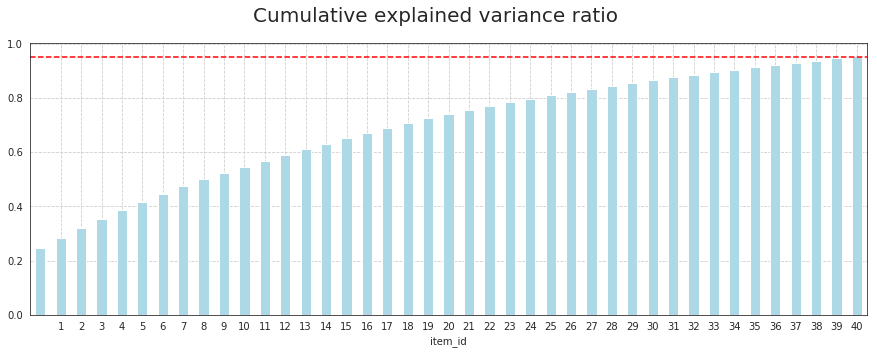

In [24]:
# Plot cumulative variance explained ratio

# Determine the number of columns to take into account
no_cols = X_transformed.shape[1]

# create a pandas.Series of the cumulative explained variance ratio
# Set the index as the column names and sort the values of the series
cum_explained_variance = pd.Series(np.cumsum(pca.explained_variance_ratio_),
                                   index = df_item_similarity.columns[:no_cols]).sort_values(ascending=True)

# Draw a barplot of 'cum_explained_variance'
fig, ax = plt.subplots(figsize=(15,5))
cum_explained_variance.plot(kind='bar', ax=ax, color='lightblue')

ax.grid(ls='--')
ax.axhline(y=percentage_variance, color='red', ls='--')
plt.suptitle('Cumulative explained variance ratio', fontsize=20)
plt.xticks(range(1,no_cols), rotation=0)
plt.show()

To capture 95% of the variance, PCA reduced the dimensionality of the dataset from 48 to 40. Not bad!

## 12. Clustering

It's now time to perform clustering using the K-Means algorithm. Since you do not know apriori the optimal number of clusters, you shall vary this number and determine the inertia as well as the average silhouette score.

**Tasks**:

- Define a list named `clusters` that contains the number of clusters ranging from 2 to 30.
- Define two empty lists named `silhouette_scores` and `inertias`.
- Iterate over the `clusters` list using `n_clusters` as a for-loop variable:

    - Instantiate a `KMeans` class with `n_clusters`; assign this instance to `kmeans`.
    - Fit `kmeans` on `X_transformed`.
    - Precict the labels of `X_transformed`, assign the result to `predicted_labels`.
    - Append the inertia of the clustering model to the list `inertias`.
    - Append the silhouette score to the list `silhouette_scores`.

In [25]:
# Perform K-means clustering for k ranging from 2 to 30 on transformed data

clusters = range(3,31)
silhouette_scores = []
inertias = []

for n_clusters in clusters:
    
    # Instantiate a KMeans object with i clusters, assign it to kmeans
    kmeans = KMeans(n_clusters=n_clusters)
    
    # Fit kmeans to X_transformed
    kmeans.fit(X_transformed)
    
    # Predict labels
    predicted_labels = kmeans.predict(X_transformed)

    # Determine inertia
    inertias.append(kmeans.inertia_)
    
    # Determine silhouette score
    score_silhouette = silhouette_score(X_transformed, predicted_labels)
    silhouette_scores.append(score_silhouette)
      
    print('Finished clustering with {0} clusters'.format(n_clusters))   

Finished clustering with 3 clusters
Finished clustering with 4 clusters
Finished clustering with 5 clusters
Finished clustering with 6 clusters
Finished clustering with 7 clusters
Finished clustering with 8 clusters
Finished clustering with 9 clusters
Finished clustering with 10 clusters
Finished clustering with 11 clusters
Finished clustering with 12 clusters
Finished clustering with 13 clusters
Finished clustering with 14 clusters
Finished clustering with 15 clusters
Finished clustering with 16 clusters
Finished clustering with 17 clusters
Finished clustering with 18 clusters
Finished clustering with 19 clusters
Finished clustering with 20 clusters
Finished clustering with 21 clusters
Finished clustering with 22 clusters
Finished clustering with 23 clusters
Finished clustering with 24 clusters
Finished clustering with 25 clusters
Finished clustering with 26 clusters
Finished clustering with 27 clusters
Finished clustering with 28 clusters
Finished clustering with 29 clusters
Finished

### Plot Inertia and Silhouette Score

Execute the following chunk of code to plot the inertia diagram as well as the silhouette plot. Review the plots to estimate the optimal number of clusters.

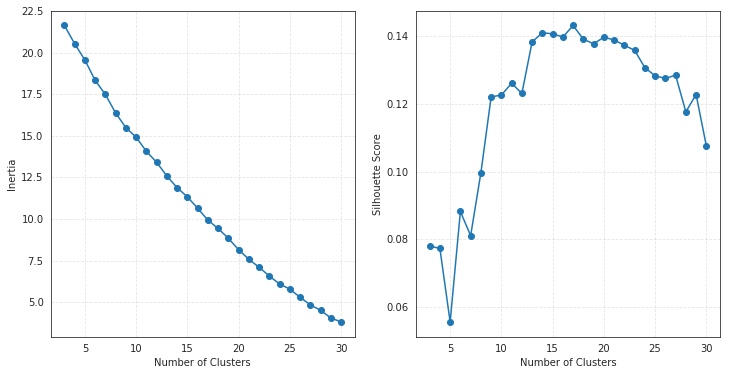

In [26]:
inertia_scores = pd.Series(inertias, index=clusters)
silhouette_scores = pd.Series(silhouette_scores, index = clusters)

fig, ax = plt.subplots(1,2, figsize=(12,6))
inertia_scores.plot(ax=ax[0], marker='o')
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('Inertia')
ax[0].grid(ls='--',alpha=0.5)

silhouette_scores.plot(ax=ax[1], marker='o')
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Silhouette Score')
ax[1].grid(ls='--',alpha=0.5)
plt.show()

## 13. Silhouette Plot

You will now draw a silhouette plot of the clustering model with the optimal number of clusters. For your convenience, the function `silhouette_plot` is written in the code chunk below. You can use it to obtain a silhouette plot of your clustering model.

**Tasks:**

- Use the graphs above to select the optimal number of clusters `n_optimal_clusters`. 
- Instantiate a `KMeans()` class with `n_clusters` set to `n_optimal_clusters`; assign the result to `kmeans`.
- Fit `kmeans` on `X_transformed`.
- Call `silhouette_plot` and pass `kmeans` and `X_transformed` as arguments.

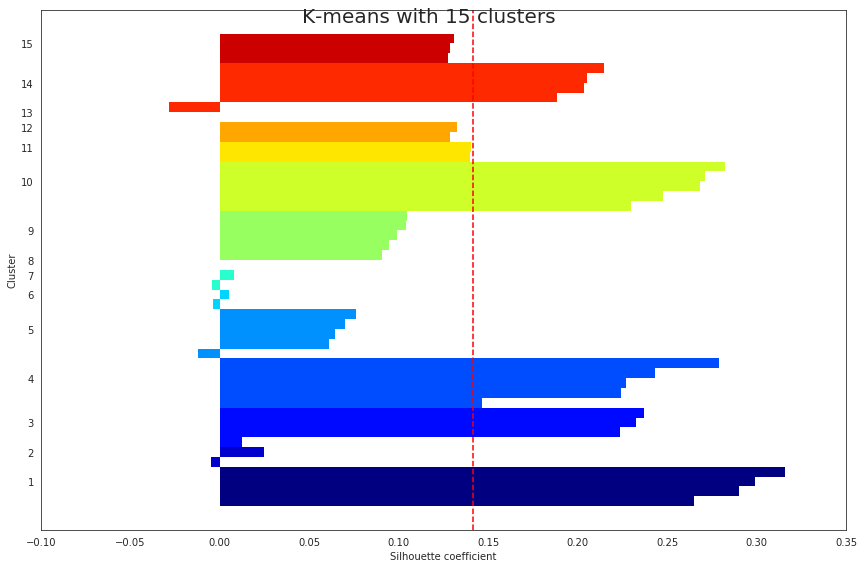

In [38]:
##########################################################################################
def silhouette_plot(model, X):
    '''
    This function draws a silhouette plot of a clustering model given the features 
    matrix X
    
    Parameters
    ---------
    model: sklean.cluster class
        The clustering model to visualize.
    
    X: A pandas.DataFrame corresponding
        The numpy.array of pandas.DataFrame corresponding to the features matrix.
    
    Returns
    -------
    plot: matplotlib figure object
        A plot showing a silhouette plot of the clusters deduced by the model on X.
   
    '''
    
    y_km = model.predict(X)
    cluster_labels = np.unique(y_km)

    n_clusters = cluster_labels.shape[0]
    
    silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
    
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    plt.figure(figsize=(12,8))
    
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
                 edgecolor='none', color=color)

        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = silhouette_score(X_transformed, y_km, metric='euclidean') 
    plt.axvline(silhouette_avg, color="red", linestyle="--") 

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')

    plt.tight_layout()
    plt.suptitle('K-means with {0} clusters'.format(len(cluster_labels)), fontsize=20)
    plt.xlim(-0.1,0.35)
    plt.show()
##########################################################################################

# Set n_optimal_clusters
n_optimal_clusters = 15

# Instantiate a KMeans 
kmeans = KMeans(n_optimal_clusters)

# Fit kmeans to X_transformed
kmeans.fit(X_transformed)

# Call silhouette plot
silhouette_plot(kmeans, X_transformed)

## 14. Visualizing the Clusters in 2D

Finally, now that you selected the optimal model, you can visualize the shape of the obtained clusters in 2D. 

You'll also examine the items forming each of the obtained clusters.

For your convenience, the function `show_clusters` is written in the code chunk below. You can call this function to produce a figure showing a projection of the data along the first two principal components. The function also outputs the items contained in each cluster. 

**Tasks:**

- Call the function `show_clusters` and pass the trained `kmeans` object as well as the dataframe `X_transformed` as arguments.
- Inspect the output and analyze whether the results make sense.

In [41]:
################################################################################################
def show_clusters(model, X):
    """
    Display a figure that shows the projection of X along the first 2 principal components
    
    Parameters
    ----------
    model: a trained sklearn.cluster class
    
    X: a pandas.DataFrame object corresponding to the PCA-reduced features matrix,
       the column names should be 'PCi' with i running from 1 to the maximum number
       of components.
    
    Returns
    -------
    plot: matplotlib figure object
    
    """
    labels = model.predict(X)

    fig = plt.figure(figsize=(15, 10))
    colors =  it.cycle (["b","g","r","c","m","y","k"])

    groups = X.groupby(labels)
    
#     ax = fig.add_subplot(111, projection='3d')
    ax = fig.add_subplot(111,)
    for (label,group) in groups:        
#         ax.scatter(group['PC1'],group['PC2'],group['PC3'],c=next(colors),label = label, )
        ax.scatter(group['PC1'],group['PC2'],c=next(colors),label = label, )

        print("\n*********** Cluster [{}] ***********\n".format(label+1))
        names = df_categories.loc[ df_categories.index.isin(group.index), 'item_name']
        for index, name in enumerate(names):
            print("\t{} {}".format(index+1,name))

    # annotate
    for itemid in X.index:
        x = X.loc[itemid,"PC1"]
        y = X.loc[itemid,"PC2"]
#         z = X.loc[itemid, "PC3"]
        name = df_categories.loc[df_categories.index == itemid,"item_name"].values[0]
#         ax.text(x,y,z,name)
        ax.text(x, y ,name)
        
    plt.legend(loc='best')
    plt.show()
################################################################################################
    
# Call show_clusters and pass X_transformed and labels as arguments
show_clusters(kmeans, X_transformed)        

# Thank you for attending the workshop!